In [1]:
import glob
import os
from astropy.io import ascii
import pylab
import numpy
from astropy.stats import mad_std


In [2]:
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/7016D/BOT_acq/v0/50454/*/Photodiode_Readings_*.txt")
files.sort(key=os.path.getmtime)

In [2]:
def mondiode_value(x,y, factor=5):
    ythresh = (max(y) - min(y))/factor + min(y)
    index = numpy.where(y < ythresh)
    y0 = numpy.median(y[index])
    y -= y0
    return sum((y[1:] + y[:-1])/2.*(x[1:] - x[:-1]))

In [3]:
from scipy.signal import medfilt

def filterfunc(x):
    return medfilt(x,5)

def readandintegrate(afile,axs,shift=None,filterfunc=lambda x: x, win=10,kwargs={},return_extra=False):
    data = ascii.read(afile)
    x, y = data["col1"], filterfunc(data["col2"])
    rising = numpy.argmax(numpy.diff(y))
    falling = numpy.argmin(numpy.diff(y))

    edges = { "rising": rising, "falling": falling }

    xedges = []
    for ax, anedge in zip(axs, edges.keys()):
        concern = edges[anedge]
        Y=numpy.diff(y)[concern-win:concern+win]
        if shift==None:
            xpeak = (x[concern-win:concern+win]*Y).sum()/Y.sum()
        else:
            xpeak=0

        edges[anedge] = {
            "x": x[concern-win:concern+win]-xpeak,
            "y": y[concern-win:concern+win]
        }
        xedges.append( xpeak )

        ax.plot( edges[anedge]["x"],edges[anedge]["y"], **kwargs )

    if return_extra:
        return { "edges": edges, "duration":xedges[-1]-xedges[0], "Q": mondiode_value(x,y), "Imax": max(y) }
    else:
        return edges
    

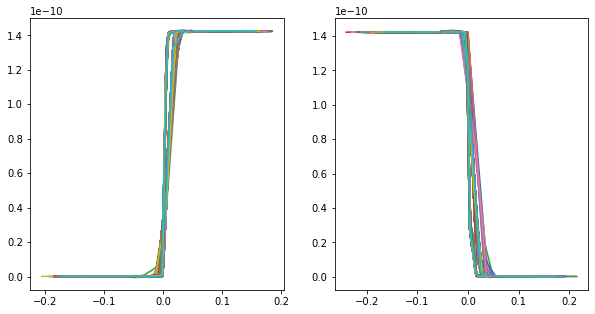

In [298]:
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/7016D/BOT_acq/v0/50454/*/Photodiode_Readings_*.txt")
files.sort(key=os.path.getmtime)
fig, axs = pylab.subplots(1, 2, figsize=(10,5),facecolor='w')

#for afile in files[:10]:
results = []
for afile in files:
    results.append( readandintegrate(afile,axs,filterfunc=filterfunc,return_extra=True) )
#    results.append( readandintegrate(afile,axs,return_extra=True) )


0.0010129292687763472
0.0028317884574582753 0.002627030630341308
0.0004991003624584022
0.000884191394019835 0.0011421618023934532
0.00013283097461059767
0.00043713493044918606 0.0004586434635494473
0.00014909988765600705
0.00020635941819902154 0.00024245901938709142
0.00019099902656303386
0.00027485052986831756 0.0004219227651152771


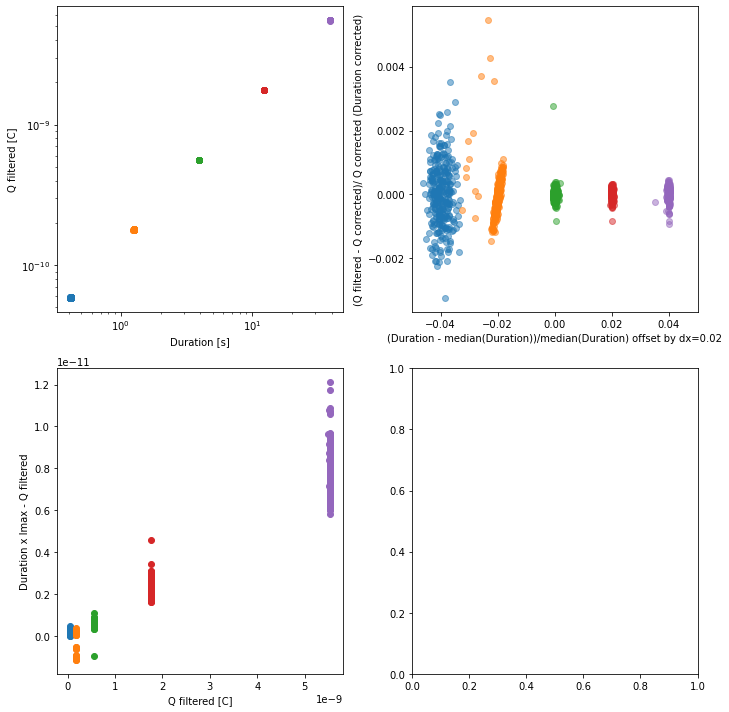

In [307]:
fig, bxs = pylab.subplots(2, 2, figsize=(10,10),facecolor='w')
bxs = bxs.flatten()

dur = numpy.array([ a["duration"] for a in results])
Q = numpy.array([ a["Q"] for a in results])
Imax = numpy.array([ a["Imax"] for a in results])
p = numpy.polyfit(dur,Q,1)
Qbar = numpy.poly1d(p)(dur)

xmin = min(dur)
xmax = max(dur)
bins = xmin*(xmax/xmin)**(numpy.arange(5)/4)
indexes = numpy.digitize( dur, (bins[1:]+bins[:-1])*0.5 )

for i in range(len(bins)):
    idx = numpy.where(indexes == i)
    x = dur[idx]
    y = Q[idx]
    imax = Imax[idx]

    p = numpy.polyfit(imax,y,1)
    correctedy = (y - numpy.poly1d(p)(imax))/numpy.poly1d(p)(imax)
    
#    bxs[0].plot( x , y, "." )
    bxs[0].errorbar( x , y, yerr=mad_std(y), fmt="o" )
#    bxs[1].errorbar( (x-numpy.median(x))/numpy.median(x)+(0.02)*i-0.04 , correctedy, fmt="o", alpha=0.5 )
    X = (x-numpy.median(x))/numpy.median(x)
    Y = correctedy
    q = numpy.polyfit(X,Y,1)
    bxs[1].errorbar( X+(0.02)*i-0.04, Y-numpy.poly1d(q)(X), fmt="o", alpha=0.5 )
    print(mad_std(Y-numpy.poly1d(q)(X)))
#    bxs[1].errorbar( numpy.median((x-numpy.median(x))/numpy.median(x))+(0.02)*i-0.04 , numpy.median(correctedy),
#                    yerr=mad_std(correctedy), fmt="o" )
    bxs[2].plot( y, imax*x-y, "o" )

    print(mad_std(correctedy),numpy.std(correctedy))
bxs[0].loglog()
bxs[1].set_xlim(-0.05, 0.05)
bxs[0].set_xlabel("Duration [s]")
bxs[0].set_ylabel("Q filtered [C]")
bxs[1].set_xlabel("(Duration - median(Duration))/median(Duration) offset by dx=0.02")
bxs[1].set_ylabel("(Q filtered - Q corrected)/ Q corrected (Duration corrected)")
bxs[2].set_xlabel("Q filtered [C]")
bxs[2].set_ylabel("Duration x Imax - Q filtered")
pylab.tight_layout()

In [4]:
def readplot(afile,axs):
    data = ascii.read(afile)
    x, y = data["col1"], data["col2"]
    ax.plot( x,y )

Text(0, 0.5, 'A')

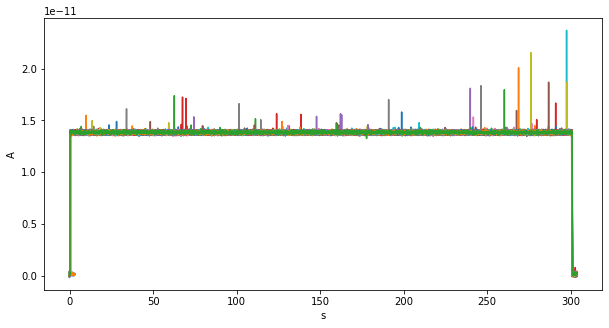

In [5]:
#files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210720ground/*/Photodiode_Readings_*.txt")
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210824long/*/Photodiode_Readings_*.txt")

files.sort(key=os.path.getmtime)
fig, axs = pylab.subplots(1, 1, figsize=(10,5),facecolor='w')
#for afile in files[:10]:
ax = axs
for afile in files:
    readplot(afile,axs)
ax.set_xlabel("s")
ax.set_ylabel("A")

Text(0, 0.5, 'A')

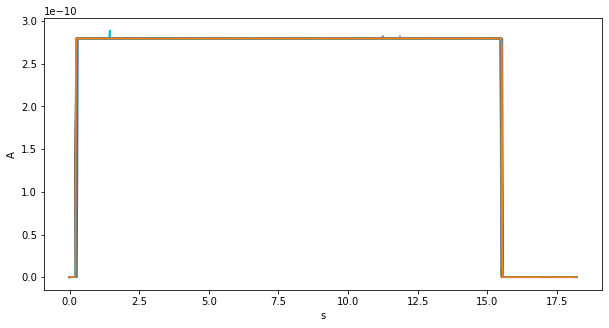

In [28]:
#files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210720ground/*/Photodiode_Readings_*.txt")
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210826/TS_C_202108*/Photodiode_Readings_*.txt")

files.sort(key=os.path.getmtime)
fig, axs = pylab.subplots(1, 1, figsize=(10,5),facecolor='w')
#for afile in files[:10]:
ax = axs
for afile in files:
    readplot(afile,axs)
ax.set_xlabel("s")
ax.set_ylabel("A")

Text(0, 0.5, 'A')

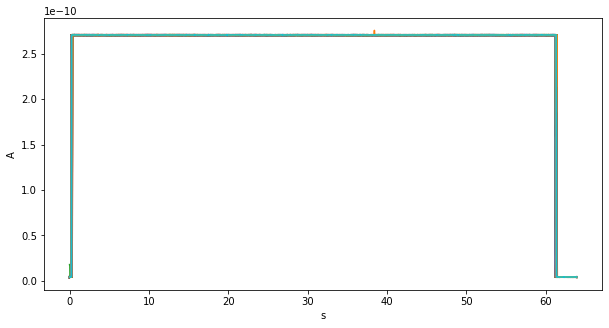

In [7]:
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210731long/*/Photodiode_Readings_*.txt")

files.sort(key=os.path.getmtime)
fig, axs = pylab.subplots(1, 1, figsize=(10,5),facecolor='w')
#for afile in files[:10]:
ax = axs
for afile in files:
    readplot(afile,axs)
ax.set_xlabel("s")
ax.set_ylabel("A")

102


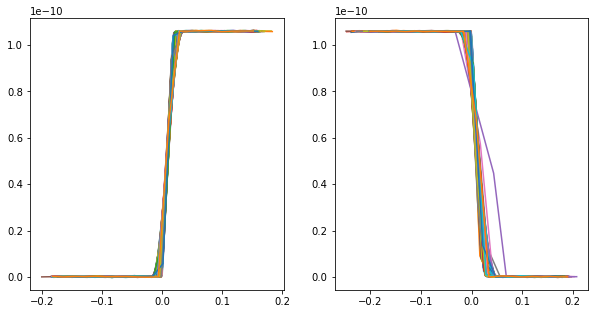

In [116]:
fig, axs = pylab.subplots(1, 2, figsize=(10,5),facecolor='w')
#for afile in files[:10]:
print(len(files))
results = []
for afile in files:
    results.append(readandintegrate(afile,axs,return_extra=True))

[31.06952947357352, 31.08443264107785, 31.079086847462545, 31.088257618956874, 31.08678629923064, 31.092626787058936, 31.086606375991344, 31.08926594721137, 31.1004696355385, 31.090607147671133, 31.09148818826199, 31.098114971383904, 31.09790478476184, 31.094979381138295, 31.098380023787715, 31.098902067650783, 31.10107905149087, 31.0987829522281, 31.095990903805493, 31.107014474312717, 31.098219038889688, 31.100146118573328, 31.099565261478883, 31.107470006918497, 31.106584908782192, 31.106378610729198, 31.111964409772472, 31.102453242432535, 31.10731823889979, 31.10523906064337, 31.105352141233737, 31.114913351421183, 31.106837235276192, 31.107302554872316, 31.10424769299459, 31.108903156114213, 31.106821447569487, 31.097154023263997, 31.112190214117128, 31.111291172879188, 31.11402692280872, 31.11327195625796, 31.114352686130008, 31.108488611505084, 31.116058715104103, 31.112039294002223, 31.11131893024494, 31.113644195008607, 31.11162738909131, 31.11067929185707, 31.11540496324717,

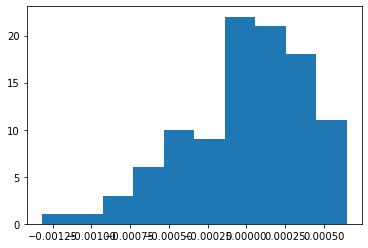

In [119]:
dur_array = [ a["duration"] for a in results ]
print(dur_array)
pylab.hist((dur_array-numpy.mean(dur_array))/numpy.mean(dur_array))
print(mad_std((dur_array-numpy.mean(dur_array))/numpy.mean(dur_array)))

66
[6.50135446e+00 6.56676450e-09]
0.0005739633010821796
0.0005734457205402608
0.0005671277660435312 0.00018269753509236113


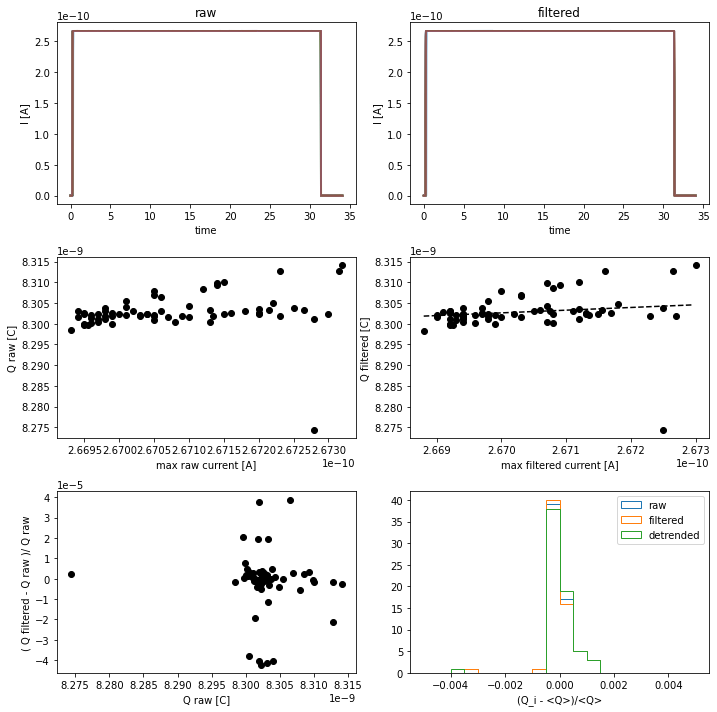

In [173]:
#files=glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210729iband/*/Photodiode_Readings_20210729*.txt")
#files=glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210729median/*/Photodiode_Readings_20210729*.txt")
files=glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210730/*/Photodiode_Readings*.txt")
#files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210720ground/*/Photodiode_Readings_*.txt")
print(len(files))
files.sort(key=os.path.getmtime)
fig, axs = pylab.subplots(3, 2, figsize=(10,10),facecolor='w')
axs = axs.flatten()
axs = [ axs[2], axs[3], axs[4], axs[5], axs[0], axs[1] ]

results = { "pd1": [] , "pd2": [], "pd2max": [] }
for i, afile in enumerate(files):
    data = ascii.read(afile)
    x, y = data["col1"], data["col2"]
    pd1 = mondiode_value(x,y)
    axs[0].scatter(y.max(), pd1, color="black" )
    pd2 = mondiode_value(x,filterfunc(y))
    axs[1].scatter(filterfunc(y).max(), pd2, color="black" )

    results["pd2max"].append(filterfunc(y).max())
        
    axs[2].scatter( pd1, (pd2-pd1)/pd1, color="black" )        
    results["pd1"].append(pd1)
    results["pd2"].append(pd2)
    axs[4].plot( x, y, label="raw" )
    axs[5].plot( filterfunc(x), filterfunc(y), label="filtered" )

p = numpy.polyfit(results["pd2max"], results["pd2"],1)
print(p)
x = numpy.arange(min(results["pd2max"]),max(results["pd2max"]),(max(results["pd2max"])-min(results["pd2max"]))/100)
axs[1].plot( x, numpy.poly1d(p)(x), "--", color="black" )

kwargs = {
    "range": (-5e-3,5e-3),
    "bins": 20,
    "histtype": "step"
}
for key, label in [
    ("pd1", "raw" ),
    ("pd2", "filtered" ),
    ]:
    mean =numpy.mean(results[key])
    print(numpy.std((results[key]-mean)/mean))
    axs[3].hist( (results[key]-mean)/mean, label=label, **kwargs )
    
detrended = (results["pd2"]-numpy.poly1d(p)(results["pd2max"]))/numpy.poly1d(p)(results["pd2max"])
axs[3].hist( detrended,
            label="detrended", **kwargs )    
print(numpy.std(detrended), mad_std(detrended))
axs[3].legend()

axs[0].set_xlabel("max raw current [A]")
axs[1].set_xlabel("max filtered current [A]")
axs[0].set_ylabel("Q raw [C]")
axs[1].set_ylabel("Q filtered [C]")
axs[2].set_xlabel("Q raw [C]")
axs[2].set_ylabel("( Q filtered - Q raw )/ Q raw")
axs[3].set_xlabel("(Q_i - <Q>)/<Q>")
axs[4].set_title("raw")
axs[4].set_xlabel("time")
axs[4].set_ylabel("I [A]")
axs[5].set_title("filtered")
axs[5].set_xlabel("time")
axs[5].set_ylabel("I [A]")
pylab.tight_layout()

101     9
100    56
dtype: int64


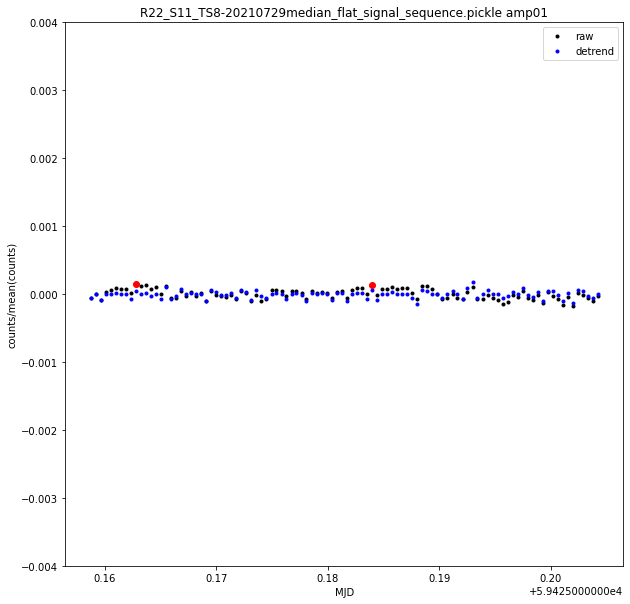

In [171]:
import pandas
#path = "/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/R22_S11_TS8-20210720ground_flat_signal_sequence.pickle"
path = "/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/R22_S11_TS8-20210729median_flat_signal_sequence.pickle"
data = pandas.read_pickle(path)
frac = data["amp01"]/data["flux"]
frac = (frac-frac.mean())/frac.mean()
outliers = numpy.argsort(frac)[::-1][:2]

fig, axs = pylab.subplots(1, 1, figsize=(10,10),facecolor='w')
pylab.plot(data["mjd"], frac, "k.", label="raw")
pylab.plot(data["mjd"], frac-filterfunc(frac), "b.", label="detrend")
pylab.plot(data["mjd"][outliers], frac[outliers], "ro")
pylab.xlabel("MJD")
pylab.ylim(-4e-3,4e-3)
pylab.ylabel("counts/mean(counts)")
pylab.title("{} amp01".format(os.path.basename(path)))
pylab.legend()
print(outliers)

[8.30323315e-09 8.30331582e-09 8.30347681e-09 8.30380889e-09
 8.30426747e-09 8.30490582e-09]
35
3.759695794399362e-05
3.759695794399362e-05
3.759695794399362e-05
3.759695794399362e-05


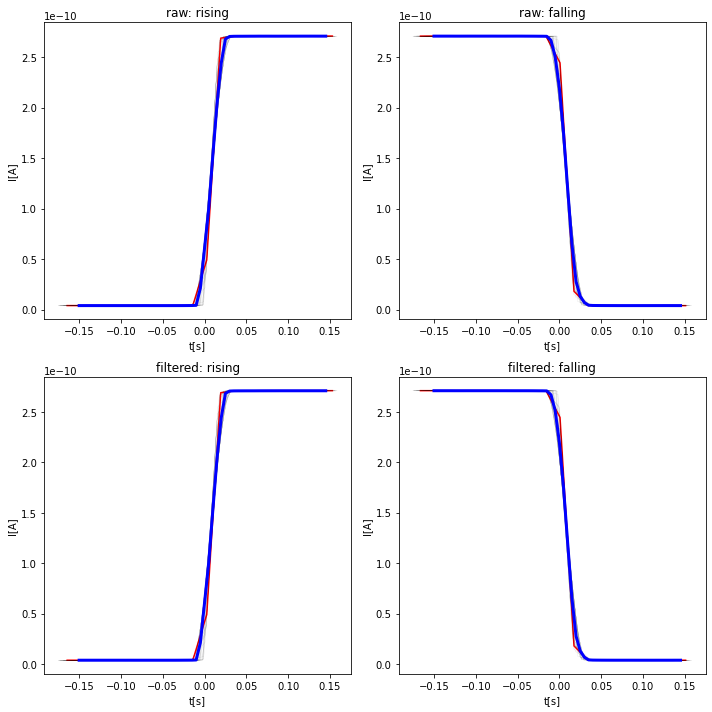

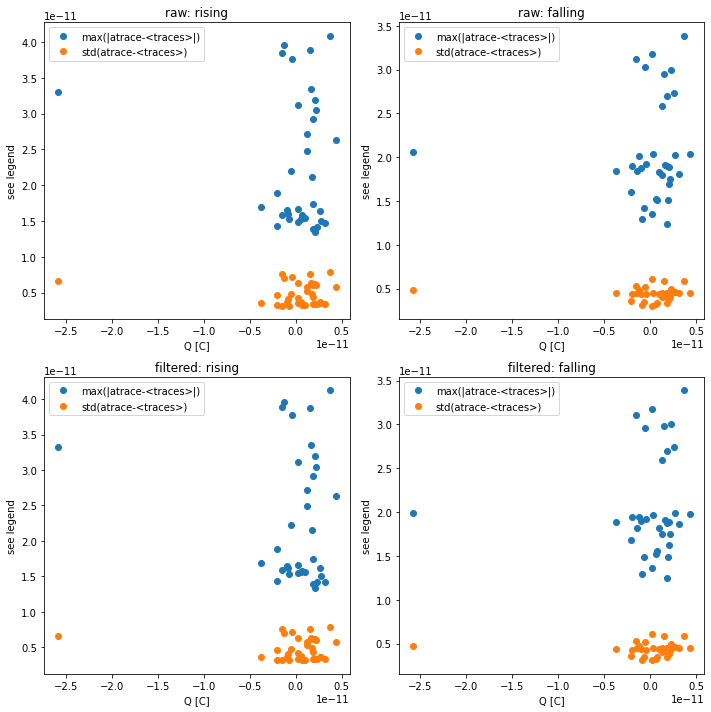

In [168]:
from astropy.stats import mad_std

figa, axs = pylab.subplots(2, 2, figsize=(10,10),facecolor='w')
figb, bxs = pylab.subplots(2, 2, figsize=(10,10),facecolor='w')

#for afile in files[:10]:
axs = axs.flatten()
bxs = bxs.flatten()
prescan = numpy.array([ mondiode_value(ascii.read(afile)["col1"], ascii.read(afile)["col2"]) for afile in files ])
idx=numpy.argsort(prescan)
print(prescan[idx[-6:]])

print(len(files))
raws = []
filters =[]
for i, afile in enumerate(files):
    if i in outliers.values:
        kwargs = { "color":"red" }
    else:
        kwargs = { "color":"black", "lw": 0.2, "alpha": 0.2 }
    raws.append(readandintegrate(afile,axs[0:2],kwargs=kwargs))
    filters.append(readandintegrate(afile,axs[2:4],filterfunc=filterfunc,kwargs=kwargs))

x = numpy.arange(-0.15,0.15,0.005)
for i, anedge in enumerate(["rising","falling"]):
    for j, traces in enumerate([ raws, filters ]):
        yarr = numpy.array([ numpy.interp(x, atrace[anedge]["x"], atrace[anedge]["y"]) for atrace in traces ])        
        y = numpy.median(yarr,axis=0)
        
        axs[i+2*j].plot(
            x,
            y,
            lw=3, color="blue"
        )
        
        std=numpy.max(numpy.abs(yarr-y),axis=1)
#        bxs[i+2*j].plot( frac-filterfunc(frac), std, "o", label="max(|atrace-<traces>|)" )
        bxs[i+2*j].plot( results["pd2"]-numpy.poly1d(p)(results["pd2max"]), std, "o", label="max(|atrace-<traces>|)" )
        std=numpy.sqrt(numpy.mean((yarr-y)**2,axis=1))        
#        bxs[i+2*j].plot( frac-filterfunc(frac), std, "o", label="std(atrace-<traces>)" )
#        bxs[i+2*j].plot( prescan, std, "o", label="std(atrace-<traces>)" )
        bxs[i+2*j].plot( results["pd2"]-numpy.poly1d(p)(results["pd2max"]), std, "o", label="std(atrace-<traces>)" )
        print(mad_std(frac-filterfunc(frac)))

for ax in [ axs, bxs ]:
    ax[0].set_title("raw: rising")
    ax[1].set_title("raw: falling")
    ax[2].set_title("filtered: rising")
    ax[3].set_title("filtered: falling")
for ax in axs:
    ax.set_xlabel("t[s]")
    ax.set_ylabel("I[A]")
for ax in bxs:
    ax.set_xlabel("Q [C]")
    ax.set_ylabel("see legend")
    ax.legend()
figa.tight_layout()
figb.tight_layout()

20 102 102 102
8 102 102 102


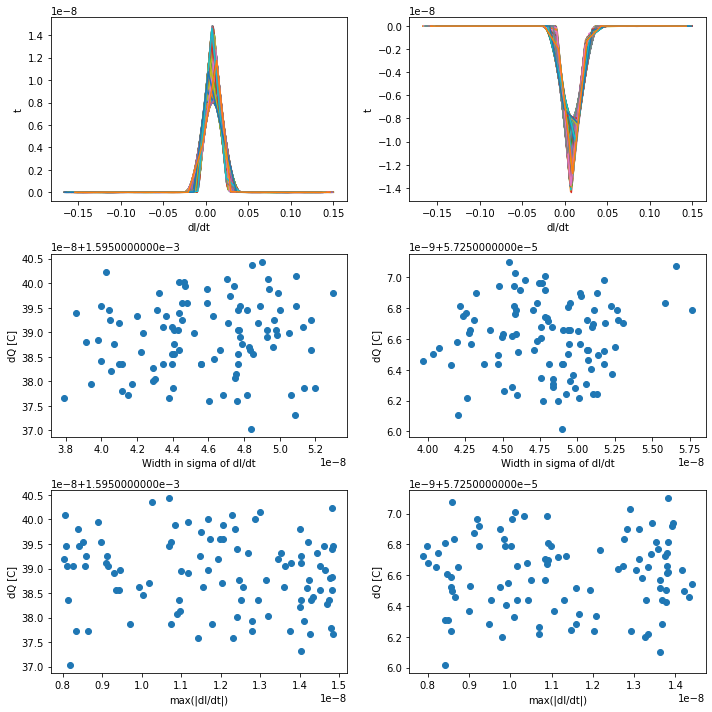

In [164]:
figa, axs = pylab.subplots(3, 2, figsize=(10,10),facecolor='w')
axs = axs.flatten()

for atrace in raws:
    for i, anedge in enumerate( atrace.keys() ):
        x = atrace[anedge]["x"]
        y = atrace[anedge]["y"]
        axs[i].plot( (x[1:]+x[:-1])*0.5, numpy.diff(y)/numpy.diff(x) )

for i, anedge in enumerate(["rising","falling"]):
    y0 = numpy.array([
            (atrace[anedge]["x"][1:]+atrace[anedge]["x"][:-1])*0.5*numpy.diff(atrace[anedge]["y"])
            for atrace in raws
        ]).mean(axis=1)
    y = numpy.array([
            ((atrace[anedge]["x"][1:]+atrace[anedge]["x"][:-1])*0.5)**2*numpy.abs(numpy.diff(atrace[anedge]["y"]))
            for atrace in raws
        ]).mean(axis=1)
    print(len(x),len(y0),len(y), len(frac))
#    axs[i+2].plot( frac, numpy.sqrt(y-y0**2), "o" )
    x = numpy.sqrt(y-y0**2)
    y = frac-filterfunc(frac)
    p = numpy.polyfit(x,y,2)
    axs[i+2].plot( x, results["pd2"]-numpy.poly1d(p)(results["pd2max"]), "o" )
    x = numpy.arange(0.4e-7,1.2e-7, 1e-8)
#    axs[i+2].plot( x, numpy.poly1d(p)(x),"--" )

    diff = numpy.array([
             numpy.max(numpy.abs(
                 numpy.diff(atrace[anedge]["y"])/numpy.diff(atrace[anedge]["x"])
                      )
                )
            for atrace in raws
        ])
    axs[i+4].plot( diff, results["pd2"]-numpy.poly1d(p)(results["pd2max"]), "o" )    

#    print(x, numpy.poly1d(p)(x))

for i in [0, 1 ]:
    axs[i].set_xlabel("dI/dt")
    axs[i].set_ylabel("t")
    
for i in [2, 3 ]:
    axs[i].set_xlabel("Width in sigma of dI/dt")
    axs[i].set_ylabel("dQ [C]")
#    axs[i].set_ylim(-1e-3,1e-3)
    
for i in [4, 5 ]:
    axs[i].set_xlabel("max(|dI/dt|)")
    axs[i].set_ylabel("dQ [C]")
#    axs[i].set_ylim(-1e-3,1e-3)
    
pylab.tight_layout()

# iband 60sec

0.0005623473734320963
0.0005613127086740779
0.00027445297484701676 0.00024119110805203791


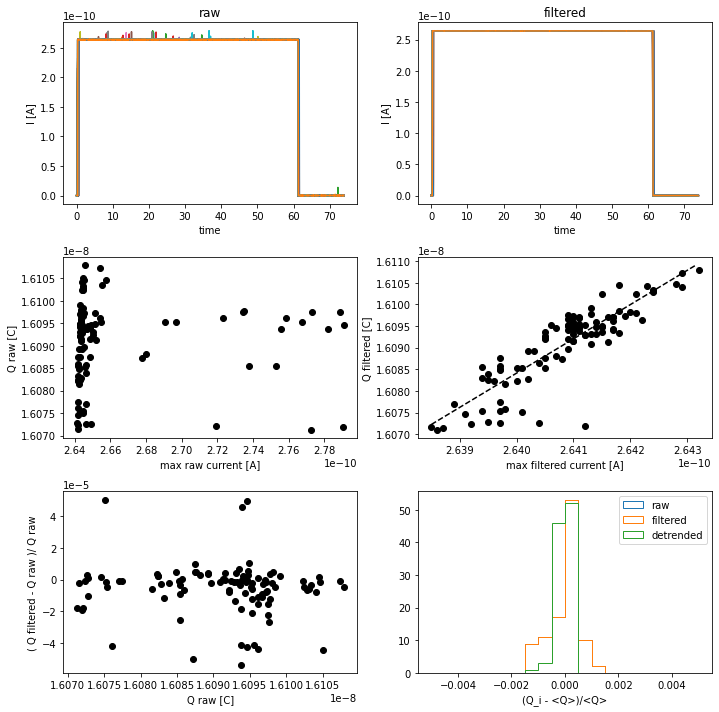

In [15]:

files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210722iband/*/Photodiode_Readings_*.txt")
files.sort(key=os.path.getmtime)
fig, axs = pylab.subplots(3, 2, figsize=(10,10),facecolor='w')
axs = axs.flatten()
axs = [ axs[2], axs[3], axs[4], axs[5], axs[0], axs[1] ]

results = { "pd1": [] , "pd2": [], "pd2max": [] }
for i, afile in enumerate(files):
    data = ascii.read(afile)
    x, y = data["col1"], data["col2"]
    pd1 = mondiode_value(x,y)
    axs[0].scatter(y.max(), pd1, color="black" )
    pd2 = mondiode_value(x,filterfunc(y))
    axs[1].scatter(filterfunc(y).max(), pd2, color="black" )

    results["pd2max"].append(filterfunc(y).max())
        
    axs[2].scatter( pd1, (pd2-pd1)/pd1, color="black" )        
    results["pd1"].append(pd1)
    results["pd2"].append(pd2)
    axs[4].plot( x, y, label="raw" )
    axs[5].plot( filterfunc(x), filterfunc(y), label="filtered" )

p = numpy.polyfit(results["pd2max"], results["pd2"],1)
x = numpy.arange(min(results["pd2max"]),max(results["pd2max"]),(max(results["pd2max"])-min(results["pd2max"]))/100)
axs[1].plot( x, numpy.poly1d(p)(x), "--", color="black" )

kwargs = {
    "range": (-5e-3,5e-3),
    "bins": 20,
    "histtype": "step"
}
for key, label in [
    ("pd1", "raw" ),
    ("pd2", "filtered" ),
    ]:
    mean =numpy.mean(results[key])
    print(numpy.std((results[key]-mean)/mean))
    axs[3].hist( (results[key]-mean)/mean, label=label, **kwargs )
    
detrended = (results["pd2"]-numpy.poly1d(p)(results["pd2max"]))/numpy.poly1d(p)(results["pd2max"])
axs[3].hist( detrended,
            label="detrended", **kwargs )    
print(numpy.std(detrended), mad_std(detrended))
axs[3].legend()

axs[0].set_xlabel("max raw current [A]")
axs[1].set_xlabel("max filtered current [A]")
axs[0].set_ylabel("Q raw [C]")
axs[1].set_ylabel("Q filtered [C]")
axs[2].set_xlabel("Q raw [C]")
axs[2].set_ylabel("( Q filtered - Q raw )/ Q raw")
axs[3].set_xlabel("(Q_i - <Q>)/<Q>")
axs[4].set_title("raw")
axs[4].set_xlabel("time")
axs[4].set_ylabel("I [A]")
axs[5].set_title("filtered")
axs[5].set_xlabel("time")
axs[5].set_ylabel("I [A]")
pylab.tight_layout()

101    19
99     36
dtype: int64


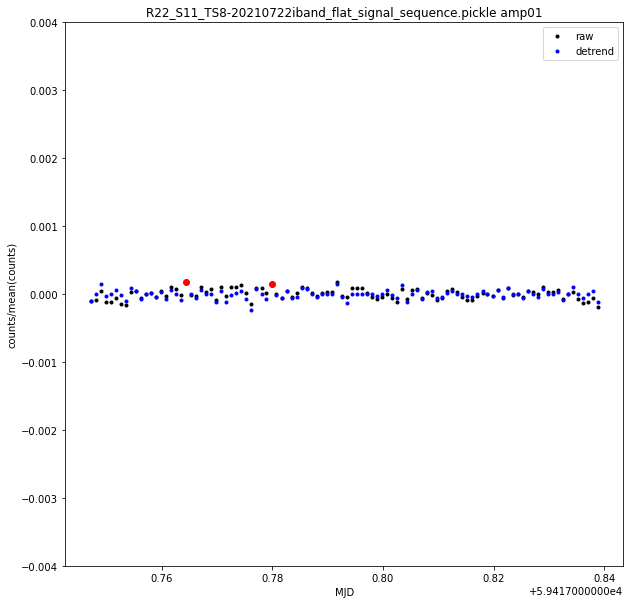

In [16]:
import pandas
path = "/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/R22_S11_TS8-20210722iband_flat_signal_sequence.pickle"
data = pandas.read_pickle(path)
frac = data["amp01"]/data["flux"]
frac = (frac-frac.mean())/frac.mean()
outliers = numpy.argsort(frac)[::-2][:2]


fig, axs = pylab.subplots(1, 1, figsize=(10,10),facecolor='w')
pylab.plot(data["mjd"], frac, "k.", label="raw")
pylab.plot(data["mjd"], frac-filterfunc(frac), "b.", label="detrend")
pylab.plot(data["mjd"][outliers], frac[outliers], "ro")
pylab.xlabel("MJD")
pylab.ylim(-4e-3,4e-3)
pylab.ylabel("counts/mean(counts)")
pylab.title("{} amp01".format(os.path.basename(path)))
pylab.legend()
print(outliers)

[1.61040832e-08 1.61045096e-08 1.61046312e-08 1.61050349e-08
 1.61073584e-08 1.61079326e-08]
102
5.9729324056894515e-05
5.9729324056894515e-05
5.9729324056894515e-05
5.9729324056894515e-05


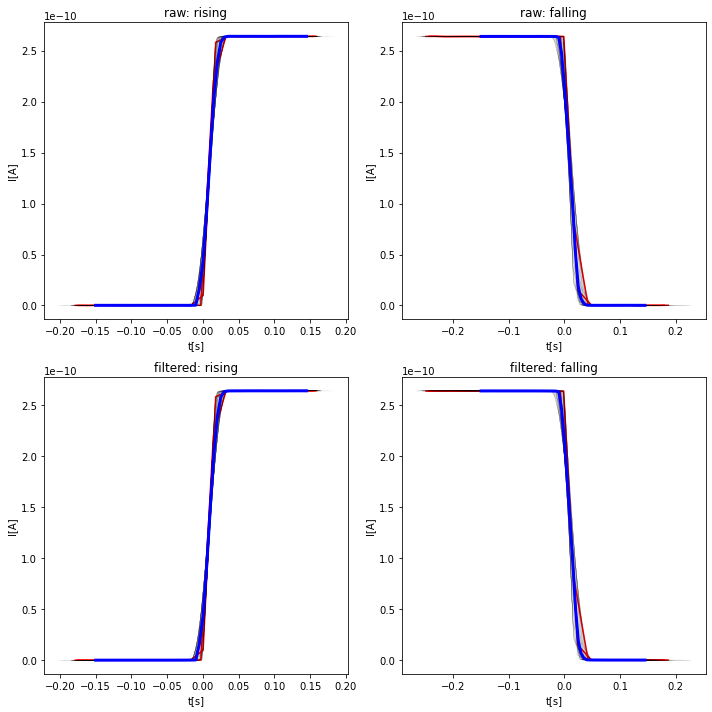

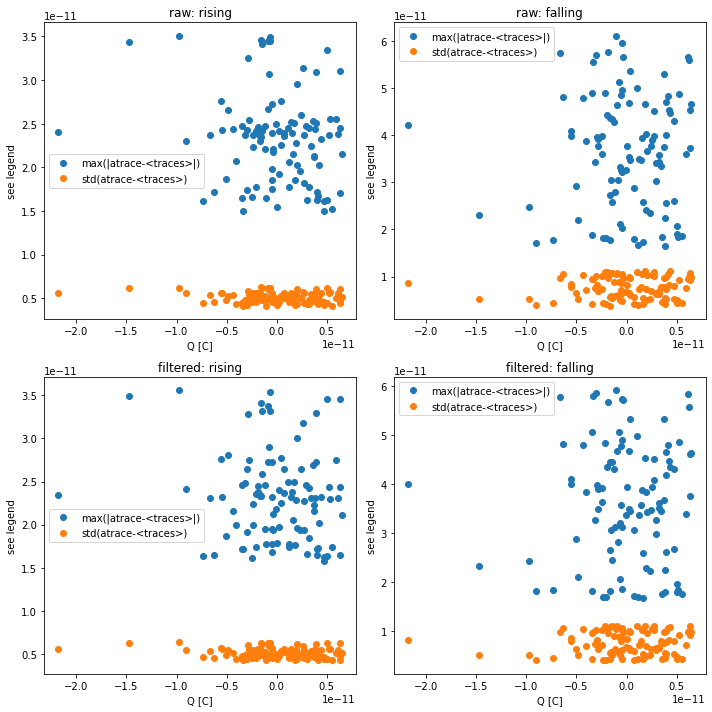

In [17]:

figa, axs = pylab.subplots(2, 2, figsize=(10,10),facecolor='w')
figb, bxs = pylab.subplots(2, 2, figsize=(10,10),facecolor='w')
#for afile in files[:10]:
axs = axs.flatten()
bxs = bxs.flatten()
prescan = numpy.array([ mondiode_value(ascii.read(afile)["col1"], ascii.read(afile)["col2"]) for afile in files ])
idx=numpy.argsort(prescan)
print(prescan[idx[-6:]])

print(len(files))
raws = []
filters =[]
for i, afile in enumerate(files):
    if i in outliers.values:
        kwargs = { "color":"red" }
    else:
        kwargs = { "color":"black", "lw": 0.2, "alpha": 0.2 }
    raws.append(readandintegrate(afile,axs[0:2],kwargs=kwargs))
    filters.append(readandintegrate(afile,axs[2:4],filterfunc=filterfunc,kwargs=kwargs))

x = numpy.arange(-0.15,0.15,0.005)
for i, anedge in enumerate(["rising","falling"]):
    for j, traces in enumerate([ raws, filters ]):
        yarr = numpy.array([ numpy.interp(x, atrace[anedge]["x"], atrace[anedge]["y"]) for atrace in traces ])        
        y = numpy.median(yarr,axis=0)
        
        axs[i+2*j].plot(
            x,
            y,
            lw=3, color="blue"
        )
        
        std=numpy.max(numpy.abs(yarr-y),axis=1)
#        bxs[i+2*j].plot( frac-filterfunc(frac), std, "o", label="max(|atrace-<traces>|)" )
        bxs[i+2*j].plot( results["pd2"]-numpy.poly1d(p)(results["pd2max"]), std, "o", label="max(|atrace-<traces>|)" )
        std=numpy.sqrt(numpy.mean((yarr-y)**2,axis=1))        
#        bxs[i+2*j].plot( frac-filterfunc(frac), std, "o", label="std(atrace-<traces>)" )
        bxs[i+2*j].plot( results["pd2"]-numpy.poly1d(p)(results["pd2max"]), std, "o", label="std(atrace-<traces>)" )
        print(mad_std(frac-filterfunc(frac)))

for ax in [ axs, bxs ]:
    ax[0].set_title("raw: rising")
    ax[1].set_title("raw: falling")
    ax[2].set_title("filtered: rising")
    ax[3].set_title("filtered: falling")
for ax in axs:
    ax.set_xlabel("t[s]")
    ax.set_ylabel("I[A]")
for ax in bxs:
    ax.set_xlabel("Q [C]")
    ax.set_ylabel("see legend")
    ax.legend()
figa.tight_layout()
figb.tight_layout()

20 102 102 102
8 102 102 102


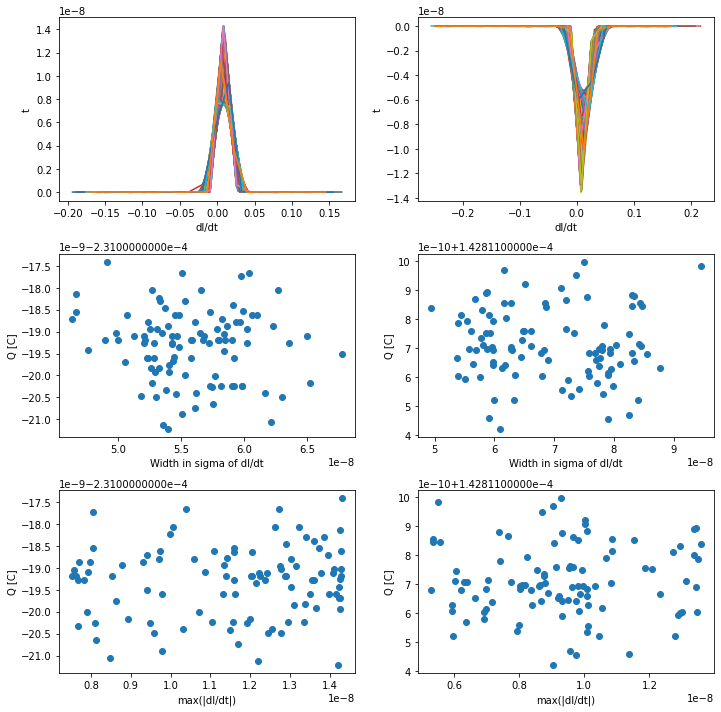

In [18]:
figa, axs = pylab.subplots(3, 2, figsize=(10,10),facecolor='w')
axs = axs.flatten()

for atrace in raws:
    for i, anedge in enumerate( atrace.keys() ):
        x = atrace[anedge]["x"]
        y = atrace[anedge]["y"]
        axs[i].plot( (x[1:]+x[:-1])*0.5, numpy.diff(y)/numpy.diff(x) )

for i, anedge in enumerate(["rising","falling"]):
    y0 = numpy.array([
            (atrace[anedge]["x"][1:]+atrace[anedge]["x"][:-1])*0.5*numpy.diff(atrace[anedge]["y"])
            for atrace in raws
        ]).mean(axis=1)
    y = numpy.array([
            ((atrace[anedge]["x"][1:]+atrace[anedge]["x"][:-1])*0.5)**2*numpy.abs(numpy.diff(atrace[anedge]["y"]))
            for atrace in raws
        ]).mean(axis=1)
    print(len(x),len(y0),len(y), len(frac))
#    axs[i+2].plot( frac, numpy.sqrt(y-y0**2), "o" )
    x = numpy.sqrt(y-y0**2)
    y = frac-filterfunc(frac)
    p = numpy.polyfit(x,y,2)
    axs[i+2].plot( x, results["pd2"]-numpy.poly1d(p)(results["pd2max"]), "o" )
    x = numpy.arange(0.4e-7,1.2e-7, 1e-8)
#    axs[i+2].plot( x, numpy.poly1d(p)(x),"--" )

    diff = numpy.array([
             numpy.max(numpy.abs(
                 numpy.diff(atrace[anedge]["y"])/numpy.diff(atrace[anedge]["x"])
                      )
                )
            for atrace in raws
        ])
    axs[i+4].plot( diff, results["pd2"]-numpy.poly1d(p)(results["pd2max"]), "o" )    

#    print(x, numpy.poly1d(p)(x))

for i in [0, 1 ]:
    axs[i].set_xlabel("dI/dt")
    axs[i].set_ylabel("t")
    
for i in [2, 3 ]:
    axs[i].set_xlabel("Width in sigma of dI/dt")
    axs[i].set_ylabel("d Q [C]")
#    axs[i].set_ylim(-1e-3,1e-3)
    
for i in [4, 5 ]:
    axs[i].set_xlabel("max(|dI/dt|)")
    axs[i].set_ylabel("d Q [C]")
#    axs[i].set_ylim(-1e-3,1e-3)
    
pylab.tight_layout()

## i short

0.0006345603331026137
0.0006350643435183352
0.0005017210063670018 0.00034973372802046983


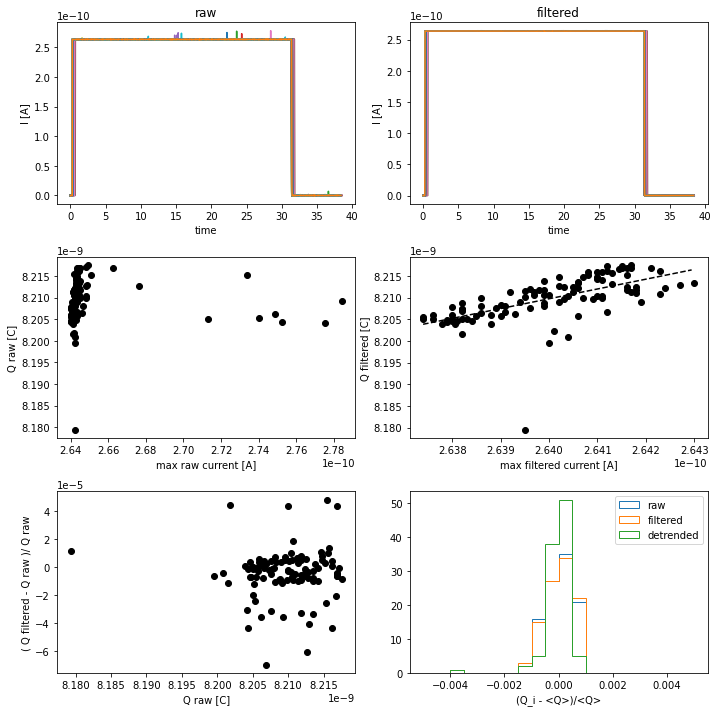

In [19]:

files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210722iband_short/*/Photodiode_Readings_*.txt")
files.sort(key=os.path.getmtime)
fig, axs = pylab.subplots(3, 2, figsize=(10,10),facecolor='w')
axs = axs.flatten()
axs = [ axs[2], axs[3], axs[4], axs[5], axs[0], axs[1] ]

results = { "pd1": [] , "pd2": [], "pd2max": [] }
for i, afile in enumerate(files):
    data = ascii.read(afile)
    x, y = data["col1"], data["col2"]
    pd1 = mondiode_value(x,y)
    axs[0].scatter(y.max(), pd1, color="black" )
    pd2 = mondiode_value(x,filterfunc(y))
    axs[1].scatter(filterfunc(y).max(), pd2, color="black" )

    results["pd2max"].append(filterfunc(y).max())
        
    axs[2].scatter( pd1, (pd2-pd1)/pd1, color="black" )        
    results["pd1"].append(pd1)
    results["pd2"].append(pd2)
    axs[4].plot( x, y, label="raw" )
    axs[5].plot( filterfunc(x), filterfunc(y), label="filtered" )

p = numpy.polyfit(results["pd2max"], results["pd2"],1)
x = numpy.arange(min(results["pd2max"]),max(results["pd2max"]),(max(results["pd2max"])-min(results["pd2max"]))/100)
axs[1].plot( x, numpy.poly1d(p)(x), "--", color="black" )

kwargs = {
    "range": (-5e-3,5e-3),
    "bins": 20,
    "histtype": "step"
}
for key, label in [
    ("pd1", "raw" ),
    ("pd2", "filtered" ),
    ]:
    mean =numpy.mean(results[key])
    print(numpy.std((results[key]-mean)/mean))
    axs[3].hist( (results[key]-mean)/mean, label=label, **kwargs )
    
detrended = (results["pd2"]-numpy.poly1d(p)(results["pd2max"]))/numpy.poly1d(p)(results["pd2max"])
axs[3].hist( detrended,
            label="detrended", **kwargs )    
print(numpy.std(detrended), mad_std(detrended))
axs[3].legend()

axs[0].set_xlabel("max raw current [A]")
axs[1].set_xlabel("max filtered current [A]")
axs[0].set_ylabel("Q raw [C]")
axs[1].set_ylabel("Q filtered [C]")
axs[2].set_xlabel("Q raw [C]")
axs[2].set_ylabel("( Q filtered - Q raw )/ Q raw")
axs[3].set_xlabel("(Q_i - <Q>)/<Q>")
axs[4].set_title("raw")
axs[4].set_xlabel("time")
axs[4].set_ylabel("I [A]")
axs[5].set_title("filtered")
axs[5].set_xlabel("time")
axs[5].set_ylabel("I [A]")
pylab.tight_layout()

101    2
99     9
dtype: int64


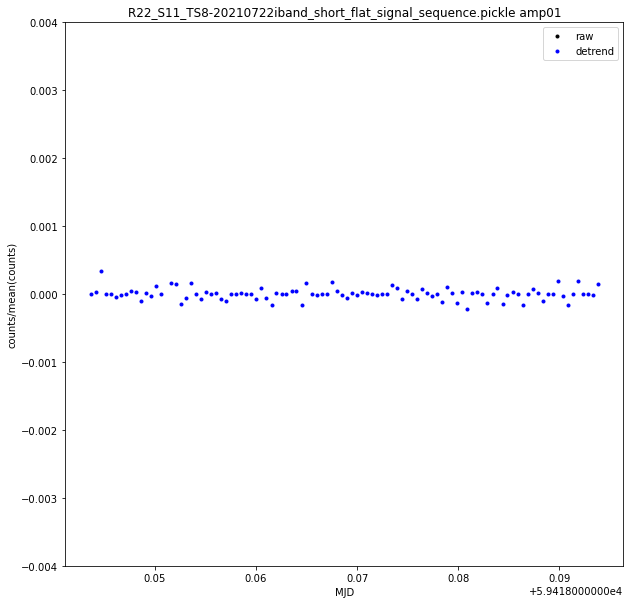

In [20]:
import pandas
path = "/gpfs/slac/lsst/fs1/g/data/youtsumi/raft_testing/flat_stability/flat_gain_results/R22_S11_TS8-20210722iband_short_flat_signal_sequence.pickle"
data = pandas.read_pickle(path)
frac = data["amp01"]/data["flux"]
frac = (frac-frac.mean())/frac.mean()
outliers = numpy.argsort(frac)[::-2][:2]


fig, axs = pylab.subplots(1, 1, figsize=(10,10),facecolor='w')
pylab.plot(data["mjd"], frac, "k.", label="raw")
pylab.plot(data["mjd"], frac-filterfunc(frac), "b.", label="detrend")
pylab.plot(data["mjd"][outliers], frac[outliers], "ro")
pylab.xlabel("MJD")
pylab.ylim(-4e-3,4e-3)
pylab.ylabel("counts/mean(counts)")
pylab.title("{} amp01".format(os.path.basename(path)))
pylab.legend()
print(outliers)

[8.21689233e-09 8.21691529e-09 8.21692093e-09 8.21692864e-09
 8.21718943e-09 8.21755189e-09]
102
4.19685121103634e-05
4.19685121103634e-05
4.19685121103634e-05
4.19685121103634e-05


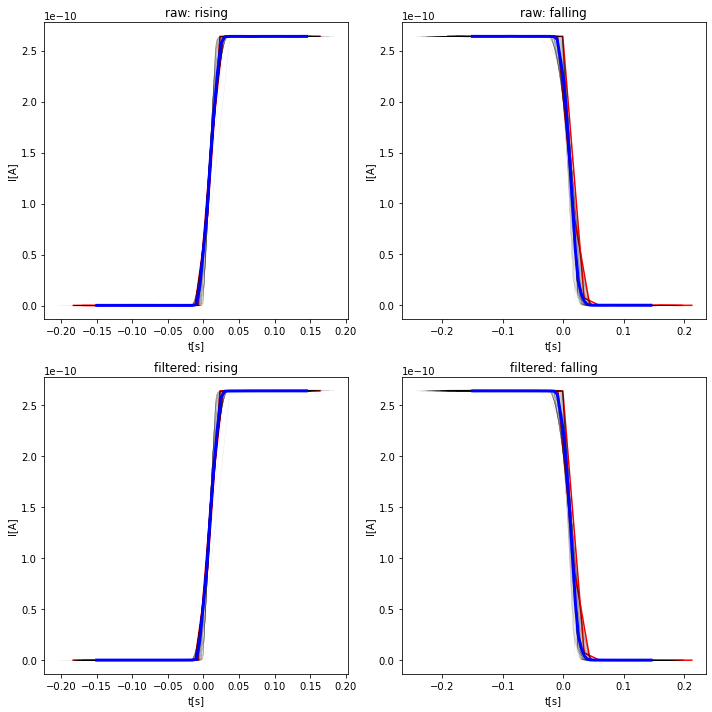

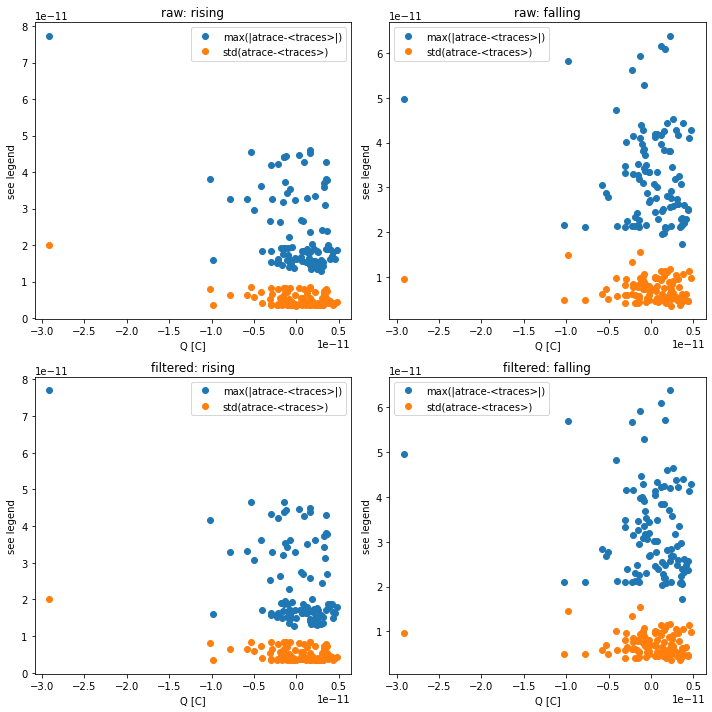

In [21]:
from astropy.stats import mad_std

figa, axs = pylab.subplots(2, 2, figsize=(10,10),facecolor='w')
figb, bxs = pylab.subplots(2, 2, figsize=(10,10),facecolor='w')
#for afile in files[:10]:
axs = axs.flatten()
bxs = bxs.flatten()
prescan = numpy.array([ mondiode_value(ascii.read(afile)["col1"], ascii.read(afile)["col2"]) for afile in files ])
idx=numpy.argsort(prescan)
print(prescan[idx[-6:]])

print(len(files))
raws = []
filters =[]
for i, afile in enumerate(files):
    if i in outliers.values:
        kwargs = { "color":"red" }
    else:
        kwargs = { "color":"black", "lw": 0.2, "alpha": 0.2 }
    raws.append(readandintegrate(afile,axs[0:2],kwargs=kwargs))
    filters.append(readandintegrate(afile,axs[2:4],filterfunc=filterfunc,kwargs=kwargs))

x = numpy.arange(-0.15,0.15,0.005)
for i, anedge in enumerate(["rising","falling"]):
    for j, traces in enumerate([ raws, filters ]):
        yarr = numpy.array([ numpy.interp(x, atrace[anedge]["x"], atrace[anedge]["y"]) for atrace in traces ])        
        y = numpy.median(yarr,axis=0)
        
        axs[i+2*j].plot(
            x,
            y,
            lw=3, color="blue"
        )
        
        std=numpy.max(numpy.abs(yarr-y),axis=1)
#        bxs[i+2*j].plot( frac-filterfunc(frac), std, "o", label="max(|atrace-<traces>|)" )
        bxs[i+2*j].plot( results["pd2"]-numpy.poly1d(p)(results["pd2max"]), std, "o", label="max(|atrace-<traces>|)" )
        std=numpy.sqrt(numpy.mean((yarr-y)**2,axis=1))        
#        bxs[i+2*j].plot( frac-filterfunc(frac), std, "o", label="std(atrace-<traces>)" )
        bxs[i+2*j].plot( results["pd2"]-numpy.poly1d(p)(results["pd2max"]), std, "o", label="std(atrace-<traces>)" )
        print(mad_std(frac-filterfunc(frac)))

for ax in [ axs, bxs ]:
    ax[0].set_title("raw: rising")
    ax[1].set_title("raw: falling")
    ax[2].set_title("filtered: rising")
    ax[3].set_title("filtered: falling")
for ax in axs:
    ax.set_xlabel("t[s]")
    ax.set_ylabel("I[A]")
for ax in bxs:
    ax.set_xlabel("Q [C]")
    ax.set_ylabel("see legend")
    ax.legend()
figa.tight_layout()
figb.tight_layout()

In [22]:
data.loc[15]

mjd       5.941805e+04
seqnum    2.800000e+01
flux      8.217107e-09
amp01    -1.407769e+04
amp02    -2.804892e+04
amp03     4.123121e+00
amp04    -2.050787e+04
amp05    -6.522736e+04
amp06    -5.349014e+04
amp07     2.852356e+04
amp08     2.192451e+04
amp09    -4.683596e+04
amp10     8.356814e+02
amp11     2.741341e+04
amp12    -2.226146e+04
amp13    -4.302074e+04
amp14     1.401574e+04
amp15    -3.510642e+04
amp16     3.614535e+03
Name: 15, dtype: float64

20 102 102 102
8 102 102 102


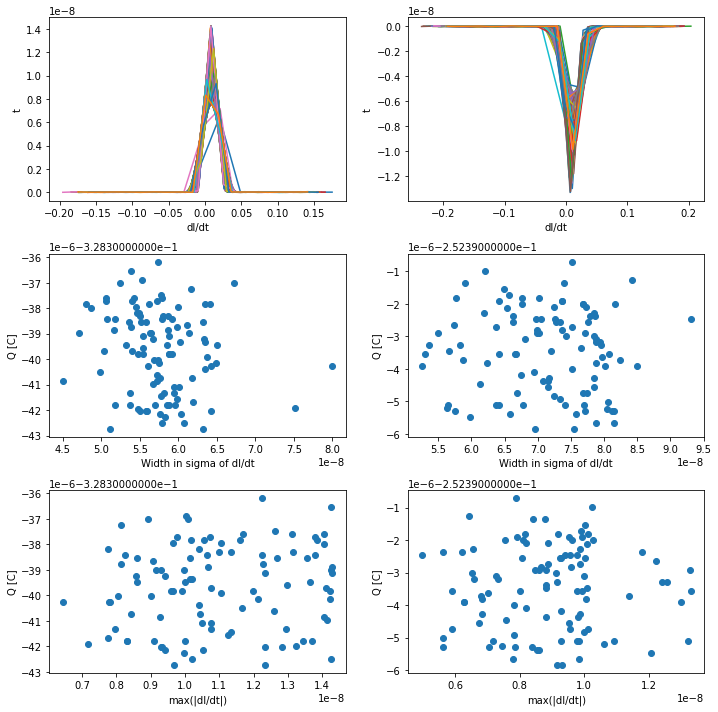

In [23]:
figa, axs = pylab.subplots(3, 2, figsize=(10,10),facecolor='w')
axs = axs.flatten()

for atrace in raws:
    for i, anedge in enumerate( atrace.keys() ):
        x = atrace[anedge]["x"]
        y = atrace[anedge]["y"]
        axs[i].plot( (x[1:]+x[:-1])*0.5, numpy.diff(y)/numpy.diff(x) )

for i, anedge in enumerate(["rising","falling"]):
    y0 = numpy.array([
            (atrace[anedge]["x"][1:]+atrace[anedge]["x"][:-1])*0.5*numpy.diff(atrace[anedge]["y"])
            for atrace in raws
        ]).mean(axis=1)
    y = numpy.array([
            ((atrace[anedge]["x"][1:]+atrace[anedge]["x"][:-1])*0.5)**2*numpy.abs(numpy.diff(atrace[anedge]["y"]))
            for atrace in raws
        ]).mean(axis=1)
    print(len(x),len(y0),len(y), len(frac))
#    axs[i+2].plot( frac, numpy.sqrt(y-y0**2), "o" )
    x = numpy.sqrt(y-y0**2)
    y = frac-filterfunc(frac)
    p = numpy.polyfit(x,y,2)
    axs[i+2].plot( x, results["pd2"]-numpy.poly1d(p)(results["pd2max"]), "o" )
    x = numpy.arange(0.4e-7,1.2e-7, 1e-8)
#    axs[i+2].plot( x, numpy.poly1d(p)(x),"--" )

    diff = numpy.array([
             numpy.max(numpy.abs(
                 numpy.diff(atrace[anedge]["y"])/numpy.diff(atrace[anedge]["x"])
                      )
                )
            for atrace in raws
        ])
    axs[i+4].plot( diff, results["pd2"]-numpy.poly1d(p)(results["pd2max"]), "o" )    

#    print(x, numpy.poly1d(p)(x))

for i in [0, 1 ]:
    axs[i].set_xlabel("dI/dt")
    axs[i].set_ylabel("t")
    
for i in [2, 3 ]:
    axs[i].set_xlabel("Width of dI/dt")
    axs[i].set_ylabel("d Q [C]")
#    axs[i].set_ylim(-1e-3,1e-3)
    
for i in [4, 5 ]:
    axs[i].set_xlabel("max(|dI/dt|)")
    axs[i].set_ylabel("d Q [C]")
#    axs[i].set_ylim(-1e-3,1e-3)
    
pylab.tight_layout()

0.0006988372155774218
0.0007085316619251591
0.0005821725481850824 0.00039243808867651063


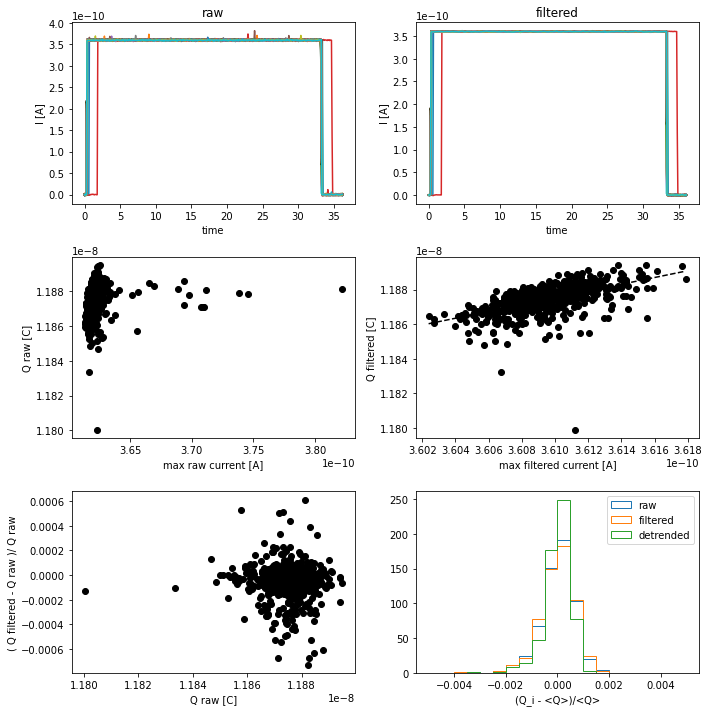

In [133]:
#files = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6798D/BOT_acq/v0/47659/*/Photodiode_Readings.txt")
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/12876/BOT_acq/v0/103412/*/Photodiode_Readings*.txt")

files.sort(key=os.path.getmtime)
fig, axs = pylab.subplots(3, 2, figsize=(10,10),facecolor='w')
axs = axs.flatten()
axs = [ axs[2], axs[3], axs[4], axs[5], axs[0], axs[1] ]

results = { "pd1": [] , "pd2": [], "pd2max": [] }
for i, afile in enumerate(files[:-20]):
    data = ascii.read(afile)
    x, y = data["col1"], data["col2"]
    pd1 = mondiode_value(x,y)
    axs[0].scatter(y.max(), pd1, color="black" )
    pd2 = mondiode_value(x,filterfunc(y))
    axs[1].scatter(filterfunc(y).max(), pd2, color="black" )

    results["pd2max"].append(filterfunc(y).max())
        
    axs[2].scatter( pd1, (pd2-pd1)/pd1, color="black" )        
    results["pd1"].append(pd1)
    results["pd2"].append(pd2)
    axs[4].plot( x, y, label="raw" )
    axs[5].plot( filterfunc(x), filterfunc(y), label="filtered" )

p = numpy.polyfit(results["pd2max"], results["pd2"],1)
x = numpy.arange(min(results["pd2max"]),max(results["pd2max"]),(max(results["pd2max"])-min(results["pd2max"]))/100)
axs[1].plot( x, numpy.poly1d(p)(x), "--", color="black" )

kwargs = {
    "range": (-5e-3,5e-3),
    "bins": 20,
    "histtype": "step"
}
for key, label in [
    ("pd1", "raw" ),
    ("pd2", "filtered" ),
    ]:
    mean =numpy.mean(results[key])
    print(numpy.std((results[key]-mean)/mean))
    axs[3].hist( (results[key]-mean)/mean, label=label, **kwargs )
    
detrended = (results["pd2"]-numpy.poly1d(p)(results["pd2max"]))/numpy.poly1d(p)(results["pd2max"])
axs[3].hist( detrended,
            label="detrended", **kwargs )    
print(numpy.std(detrended), mad_std(detrended))
axs[3].legend()

axs[0].set_xlabel("max raw current [A]")
axs[1].set_xlabel("max filtered current [A]")
axs[0].set_ylabel("Q raw [C]")
axs[1].set_ylabel("Q filtered [C]")
axs[2].set_xlabel("Q raw [C]")
axs[2].set_ylabel("( Q filtered - Q raw )/ Q raw")
axs[3].set_xlabel("(Q_i - <Q>)/<Q>")
axs[4].set_title("raw")
axs[4].set_xlabel("time")
axs[4].set_ylabel("I [A]")
axs[5].set_title("filtered")
axs[5].set_xlabel("time")
axs[5].set_ylabel("I [A]")
pylab.tight_layout()

In [24]:
data

,mjd,seqnum,flux,amp01,amp02,amp03,amp04,amp05,amp06,amp07,amp08,amp09,amp10,amp11,amp12,amp13,amp14,amp15,amp16
0,59418.043655,6,8.186613e-09,46175.738281,46363.609375,46168.507812,46278.976562,46216.160156,46455.269531,46442.714844,46526.007812,44460.800781,44614.949219,44606.218750,44536.003906,44572.857422,44762.294922,44388.007812,44163.011719
1,59418.044135,7,8.203892e-09,46284.300781,46472.714844,46275.712891,46386.056641,46323.937500,46564.560547,46552.191406,46631.804688,44563.011719,44721.425781,44712.683594,44640.294922,44677.619141,44869.218750,44492.597656,44266.082031
2,59418.044645,9,8.203939e-09,46298.886719,46486.125000,46290.876953,46401.466797,46338.199219,46579.289062,46567.203125,46646.044922,44575.666016,44734.695312,44725.101562,44652.023438,44688.550781,44881.078125,44504.455078,44278.777344
3,59418.045124,10,8.206559e-09,46298.121094,46486.935547,46291.013672,46401.121094,46339.359375,46580.798828,46567.566406,46645.693359,44575.781250,44733.990234,44727.107422,44653.300781,44692.054688,44883.396484,44505.421875,44280.660156
4,59418.045635,12,8.209781e-09,46314.429688,46502.187500,46308.205078,46417.265625,46355.246094,46596.570312,46582.712891,46661.992188,44592.207031,44750.027344,44743.156250,44668.984375,44707.476562,44898.542969,44520.363281,44296.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,59418.091824,151,8.209271e-09,46310.546875,46498.896484,46303.460938,46413.589844,46352.638672,46592.841797,46580.615234,46658.703125,44590.716797,44747.109375,44736.382812,44661.433594,44700.531250,44890.824219,44513.714844,44289.587891
98,59418.092336,153,8.209093e-09,46300.757812,46489.642578,46294.562500,46403.914062,46341.875000,46584.250000,46570.867188,46648.968750,44583.291016,44739.566406,44729.492188,44655.906250,44694.703125,44884.800781,44508.097656,44283.156250
99,59418.092817,154,8.209562e-09,46307.753906,46496.582031,46302.070312,46411.210938,46347.908203,46588.220703,46575.914062,46654.507812,44588.007812,44746.269531,44734.707031,44659.304688,44698.705078,44888.380859,44512.398438,44287.689453
100,59418.093335,156,8.212362e-09,46318.431641,46507.230469,46311.757812,46421.759766,46360.957031,46601.886719,46588.429688,46667.021484,44599.589844,44756.287109,44746.230469,44672.406250,44711.054688,44900.558594,44524.074219,44298.837891


NameError: name 'outliers' is not defined

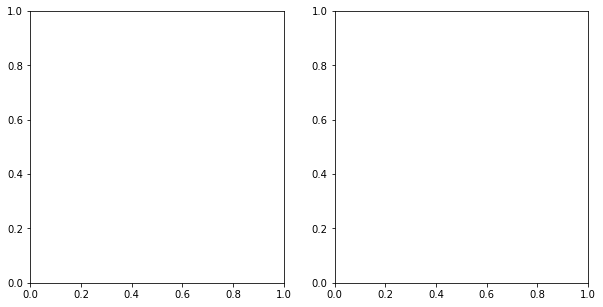

In [135]:
figa, axs = pylab.subplots(1, 2, figsize=(10,5),facecolor='w')
axs = axs.flatten()

files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210722iband_short/*/Photodiode_Readings_*.txt")
sub=files[0:3]
print(sub, numpy.array(files)[outliers])
files.sort(key=os.path.getmtime)
for i, func in enumerate([ numpy.argmax, numpy.argmin ]):
    for apath in numpy.array(files)[outliers]:
        data=ascii.read(apath)
        idxmax = func(numpy.diff(data["col2"]))
        concern=10
        xt=(((data["col1"][:-1]+data["col1"][1:])*0.5*numpy.diff(data["col2"]))[idxmax-concern:idxmax+concern]).sum()/numpy.diff(data["col2"])[idxmax-concern:idxmax+concern].sum()
        axs[i].plot(data["col1"]-xt,data["col2"])
        axs[i].set_xlim(-0.05,0.05)

In [ ]:
figa, axs = pylab.subplots(2, 1, figsize=(10,5),facecolor='w')
axs = axs.flatten()

for afile in numpy.array(files)[outliers]:
    data=ascii.read(apath)
    axs[0].plot(data["col1"], data["col2"])
    axs[1].plot( numpy.diff(data["col1"]) )
    dx = numpy.diff(data["col1"])
    print( data[numpy.argmax(dx)-10:numpy.argmax(dx)+10],
          dx[numpy.argmax(dx)-10:numpy.argmax(dx)+10])
    print(mondiode_value(data["col1"], data["col2"]))
#    axs[1].axhspan( dx.mean()-dx.std(), dx.mean()+dx.std() )


(2.6315695911259764e-10, 2.6434304088740235e-10)

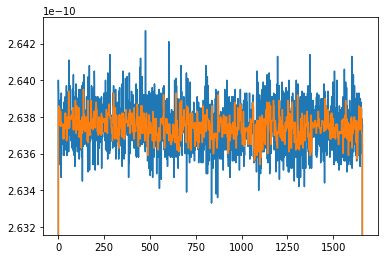

In [136]:
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210722iband_short/*/Photodiode_Readings_*.txt")
afile = files[1]
data = ascii.read(afile)
x = data["col1"]
y = data["col2"]
factor = 5

ythresh = (max(y) - min(y))/factor + min(y)
index = numpy.where(y > ythresh)

mad_std(y[index])/numpy.median(y[index]),mad_std(y[index]),numpy.median(y[index]),len(y[index])
pylab.plot( y[index])
pylab.plot( filterfunc(y[index]))
pylab.ylim( numpy.median(y[index])-5*mad_std(y[index]), numpy.median(y[index])+5*mad_std(y[index]) )

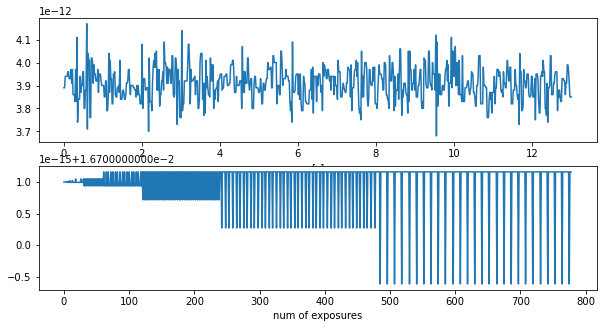

In [151]:
#files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210729iband/*/Photodiode_Readings_20210729*.txt")
files = ["/gpfs/slac/lsst/fs1/g/data/youtsumi/pd_monitoring/testarea/Photodiode_Readings_20210729_000000.txt"]
figa, axs = pylab.subplots(2, 1, figsize=(10,5),facecolor='w')
axs = axs.flatten()

for afile in numpy.array(files):
    data=ascii.read(afile)
    axs[0].plot(data["col1"], data["col2"])
    axs[1].plot( numpy.diff(data["col1"]) )
    dx = numpy.diff(data["col1"])
#    print( data[numpy.argmax(dx)-10:numpy.argmax(dx)+10],
#          dx[numpy.argmax(dx)-10:numpy.argmax(dx)+10])
#    print(mondiode_value(data["col1"], data["col2"]))
axs[0].set_xlabel("[s]")
axs[1].set_xlabel("num of exposures")

fig.tight_layout()


<ipython-input-309-2b8fbf7f9a8e>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _, y, std = numpy.array( res ).T


(-0.1, 1.1)

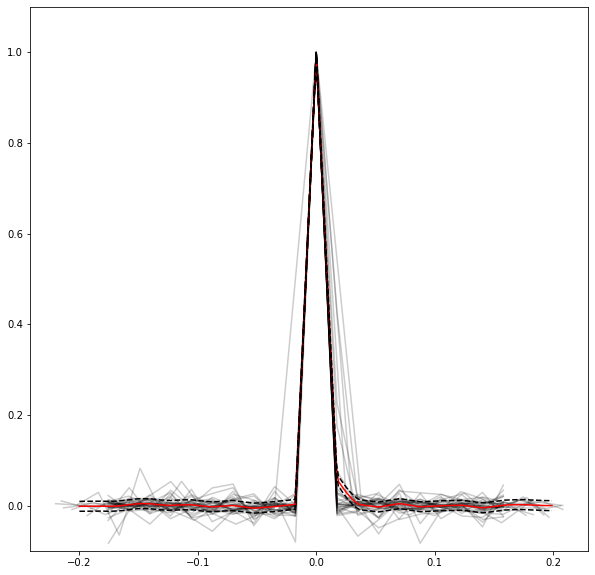

In [309]:
from scipy.ndimage import gaussian_filter1d
filterfunc = lambda x: gaussian_filter1d(x, 40.)

figa, axs = pylab.subplots(1, 1, figsize=(10,10),facecolor='w')

from astropy.table import Table
#files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210722iband/*/Photodiode_Readings_*.txt")
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210722*/*/Photodiode_Readings_*.txt")
#files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210731/*/Photodiode_Readings_*.txt")
files.sort(key=os.path.getmtime)
files = files
factor=0.9
dx = 10
x = numpy.arange(-0.2,0.2,0.00167)
res = []
for afile in files:
    try:
        data=ascii.read(afile)
        on = data["col2"]>data["col2"].max()*factor
        peakids = numpy.where((data["col2"] - data["col2"][on].mean()) > 20*data["col2"][on].std())
        if len(peakids[0])==0:
            continue


        for peakid in peakids[0]:
            xp = data["col1"][peakid-dx:peakid+dx]
            yp = data["col2"][peakid-dx:peakid+dx]
            yp = yp-numpy.median(yp)
#            xc = (xp*filterfunc(yp)).sum() / filterfunc(yp).sum()
            xc = xp[numpy.argmax(yp)]
            pylab.plot( xp-xc, yp/yp.max(), color="k", alpha=0.2 )
            y = numpy.interp( x, xp-xc, yp/yp.max() )
            res.append( ( x, y, mad_std(yp) ) )
    except:
        pass

_, y, std = numpy.array( res ).T

Y = numpy.average( y, weights=1/std**2 )
Y2 = numpy.average( y**2, weights=1/std**2 )
yerr=numpy.sqrt(Y2.mean()-Y.mean()**2)/numpy.sqrt(len(Y))
pylab.plot( x, Y, color="r" )
pylab.plot( x, Y-yerr, "k--")
pylab.plot( x, Y+yerr, "k--")
pylab.ylim(-0.1,1.1)

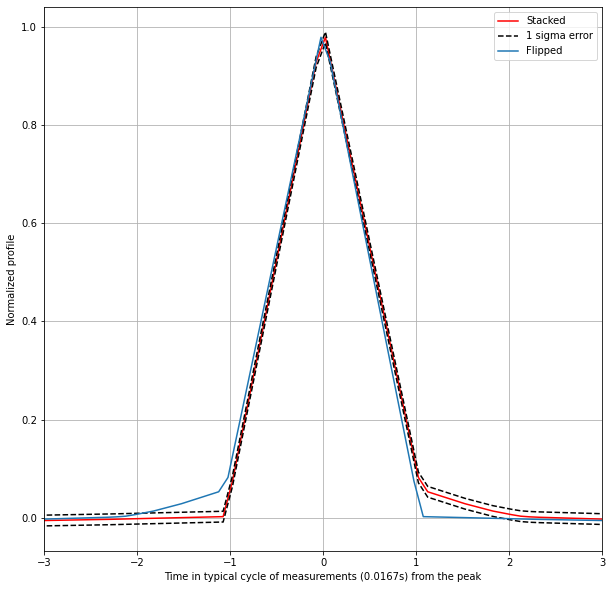

In [295]:

figa, axs = pylab.subplots(1, 1, figsize=(10,10),facecolor='w')

Y = numpy.average( y, weights=1/std**2 )
Y2 = numpy.average( y**2, weights=1/std**2 )
yerr=numpy.sqrt(Y2.mean()-Y.mean()**2)/numpy.sqrt(len(Y))
dx = 0.0167
pylab.plot( x/dx, Y, color="r", label="Stacked" )
pylab.plot( x/dx, Y-yerr, "k--", label="1 sigma error")
pylab.plot( x/dx, Y+yerr, "k--")
pylab.plot(-x/dx, Y, label="Flipped" )
pylab.xlabel("Time in typical cycle of measurements (0.0167s) from the peak")
pylab.ylabel("Normalized profile")
pylab.legend()
pylab.xlim(-3,3)
pylab.grid()